In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import numpy as np
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
from skbio.stats.ordination import pcoa
from skbio.diversity.beta import unweighted_unifrac
from copy import deepcopy
%matplotlib inline

# Read data

In [2]:
# # the following code generates input data for brad_assign_color
# df_tax = pd.read_csv('taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
# df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
# df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
# df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]
# for symbol, level in zip(['d__','p__','c__','o__','f__','g__'], ['Kingdom','Phylum','Class','Order','Family','Genus']):
#     df_tax[level] = [x.split(symbol)[1].split(';')[0] if symbol in x else '<not present>' for x in df_tax.Taxon]
# df_tax.to_csv("generate_color/taxonomy.csv", index=0)

In [3]:
df_tax = pd.read_csv("generate_color/tblASVtaxonomy_silva138_new.csv")
anaerostipes_asvs = list(df_tax.loc[df_tax.Taxon.str.contains('Anaerostipes'), 'ASV'].values)
df_tax.head()

,ASV,Taxon,Confidence,LowestTaxonomy,Kingdom,Phylum,Class,Order,Family,Genus,HexColor,ColorOrder
0,0000063f916bcbc101a7d1192bdf218c,d__Bacteria; p__Firmicutes; c__Clostridia,0.931212,c__Clostridia,Bacteria,Firmicutes,Clostridia,<not present>,<not present>,<not present>,#BEA89A,105
1,00001097743792efbd3de05768b590e5,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.962084,s__uncultured_bacterium,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Muribaculaceae,Muribaculaceae,#D0D0D0,147
2,000366f526e20feab87efde6aa915cb5,d__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.999434,g__Streptococcus,Bacteria,Firmicutes,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,#AFCF3C,42
3,0004aff5c9cfe6692009dacab4daa0bd,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.989491,f__Ruminococcaceae,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,<not present>,#BEA89A,105
4,00082f46ad627ae8aea34434209c2e19,d__Bacteria; p__Firmicutes; c__Negativicutes; ...,0.976288,g__Selenomonas,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Selenomonas,#D0D0D0,147


In [4]:
len(anaerostipes_asvs)

94

In [5]:
df_meta = pd.read_csv("sample-metadata.tsv", sep="\t", skiprows=[1], index_col=0)
df_meta.head()

,SampleDetails,MouseID,Day,Facility,Antibiotic,Concentration_gL,Probiotic,FecalWeight_mg
SampleID,,,,,,,,
d0_001,"Amp 0.5g/L, EM04",m001,0,EM04,Amp,0.5,No,17.0
d7_001,"Amp 0.5g/L, EM04, +Ah",m001,7,EM04,Amp,0.5,Ah,34.1
d14_001,"Amp 0.5g/L, EM04, +Ah+Cp",m001,14,EM04,Amp,0.5,Ah/Cp,NaN
d0_002,"Amp 0.5g/L, EM04",m002,0,EM04,Amp,0.5,No,31.0
d7_002,"Amp 0.5g/L, EM04, +Ah",m002,7,EM04,Amp,0.5,Ah,32.5


In [6]:
df_count = pd.read_csv("feature-table.from_biom.txt", sep="\t", skiprows=[0], index_col=0)
df_count = df_count.loc[df_tax['ASV']]
df_count = df_count.loc[~(df_count==0).all(axis=1)]
df_count = df_count[df_meta.index]
df_relabun = df_count.div(df_count.sum(axis=0), axis=1)
df_relabun.head()

,d0_001,d7_001,d14_001,d0_002,d7_002,d14_002,d0_003,d7_003,d14_003,d0_004,...,d0_021,d7_021,d0_022,d7_022,d0_023,d7_023,EM04_03,RB15_03,EM04_04,RB15_04
#OTU ID,,,,,,,,,,,,,,,,,,,,,
0000063f916bcbc101a7d1192bdf218c,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
00001097743792efbd3de05768b590e5,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
000366f526e20feab87efde6aa915cb5,0.0,0.0,0.0,0.000553,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
0004aff5c9cfe6692009dacab4daa0bd,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00014,0.0,0.0,0.0
00082f46ad627ae8aea34434209c2e19,0.0,0.0,0.0,0.000991,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [7]:
# df_count = pd.read_csv("feature-table.from_biom.txt", sep="\t", skiprows=[0], index_col=0).stack().reset_index()
# df_count.columns = ['ASV','SampleID','Count']
# df_count = df_count[df_count.Count>0]
# df_count = df_count[df_count.ASV.isin(df_tax.ASV)]
# df_count.to_csv("generate_color/tblcounts_asv_melt.csv", index=False)

In [8]:
df_anaerostipes_total = df_relabun.loc[anaerostipes_asvs].sum(axis=0).to_frame().rename({0:'Anaerostipes_sum'}, axis=1)
df_meta = pd.merge(df_meta, df_anaerostipes_total, left_index=True, right_index=True, how='left')
df_meta.head()

,SampleDetails,MouseID,Day,Facility,Antibiotic,Concentration_gL,Probiotic,FecalWeight_mg,Anaerostipes_sum
SampleID,,,,,,,,,
d0_001,"Amp 0.5g/L, EM04",m001,0,EM04,Amp,0.5,No,17.0,0.005711
d7_001,"Amp 0.5g/L, EM04, +Ah",m001,7,EM04,Amp,0.5,Ah,34.1,0.003568
d14_001,"Amp 0.5g/L, EM04, +Ah+Cp",m001,14,EM04,Amp,0.5,Ah/Cp,NaN,0.000732
d0_002,"Amp 0.5g/L, EM04",m002,0,EM04,Amp,0.5,No,31.0,0.005140
d7_002,"Amp 0.5g/L, EM04, +Ah",m002,7,EM04,Amp,0.5,Ah,32.5,0.007225


In [10]:
df_meta.sort_values('Anaerostipes_sum', ascending=False).to_csv("anaerostipes_sum.csv")

# Run PCA

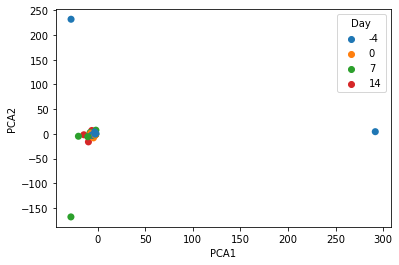

In [33]:
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2, random_state=42))])
pca_data = pipeline.fit_transform(df_relabun.T.values)
pca_df = pd.DataFrame(data=np.vstack((pca_data.T, df_meta.index, df_meta.MouseID, df_meta.Day, df_meta.Facility, df_meta.Antibiotic, df_meta.Concentration_gL, df_meta.Probiotic)).T, 
                       columns=('PCA1', 'PCA2', 'SampleID','MouseID','Day','Facility','Antibiotic','Concentration_gL','Probiotic'))
pca_df.PCA1 = pca_df.PCA1.astype(float)
pca_df.PCA2 = pca_df.PCA2.astype(float)
pca_df.to_csv('pca.csv', index=False)

_ = sns.scatterplot(x='PCA1', y='PCA2', hue='Day', edgecolor='None', data=pca_df, s=50, palette='tab10')

# Run tsne

/Users/liaoc/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


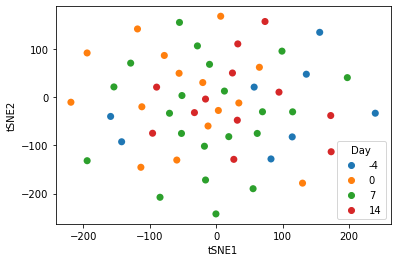

In [34]:
pipeline = Pipeline([('scaling', StandardScaler()), ('tsne', TSNE(n_components=2, random_state=42, verbose=0, n_jobs=-1, n_iter=5000, metric='braycurtis'))])
tsne_data = pipeline.fit_transform(df_relabun.T.values)
tsne_df = pd.DataFrame(data=np.vstack((tsne_data.T, df_meta.MouseID, df_meta.Day, df_meta.Facility, df_meta.Antibiotic, df_meta.Concentration_gL, df_meta.Probiotic)).T, 
                       columns=('tSNE1', 'tSNE2', 'MouseID','Day','Facility','Antibiotic','Concentration_gL','Probiotic'))
tsne_df.tSNE1 = tsne_df.tSNE1.astype(float)
tsne_df.tSNE2 = tsne_df.tSNE2.astype(float)
tsne_df.to_csv('tsne.csv', index=False)

_ = sns.scatterplot(x='tSNE1', y='tSNE2', hue='Day', edgecolor='None', data=tsne_df, s=50, palette='tab10')

# Run Pcoa (Braycurtise)

In [57]:
distm = pairwise_distances(df_relabun.T, metric='braycurtis', n_jobs=-1)
pcoa_obj = pcoa(distm, method='eigh', number_of_dimensions=2, inplace=False)
pcoa_df = pd.DataFrame(data=np.vstack((pcoa_obj.samples.T, df_meta.index, df_meta.SampleDetails, df_meta.MouseID, df_meta.Day, df_meta.Facility, df_meta.Antibiotic, df_meta.Concentration_gL, df_meta.Probiotic, df_meta.Anaerostipes_sum)).T, 
                       columns=('PCoA1', 'PCoA2', 'SampleID','SampleDetails','MouseID','Day','Facility','Antibiotic','Concentration_gL','Probiotic','Anaerostipes_sum'))
pcoa_df.PCoA1 = pcoa_df.PCoA1.astype(float)
pcoa_df.PCoA2 = pcoa_df.PCoA2.astype(float)
pcoa_df.to_csv('pcoa.csv', index=False)

## Compare Facility

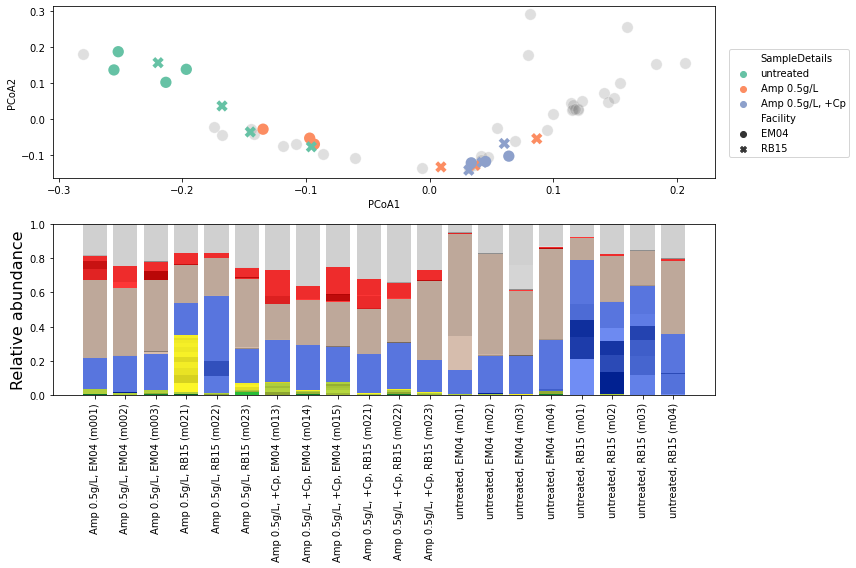

In [157]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

# plot PCOA
df2plot = deepcopy(pcoa_df)
df2plot.loc[~df2plot.SampleDetails.isin([
    'untreated, RB15','untreated, EM04',
    'Amp 0.5g/L, RB15','Amp 0.5g/L, EM04',
    'Amp 0.5g/L, RB15, +Cp','Amp 0.5g/L, EM04, +Cp'
]), 'SampleDetails'] = 'Other'
df2plot['SampleDetails'] = [x.replace(', RB15','').replace(', EM04','') for x in df2plot.SampleDetails]
df2plot = df2plot.sort_values(['SampleDetails','Facility'])

_ = sns.scatterplot(x='PCoA1', y='PCoA2', hue='SampleDetails', style='Facility', edgecolor='None', data=df2plot[df2plot.SampleDetails!='Other'], s=128, palette='Set2', ax=ax[0], hue_order=['untreated','Amp 0.5g/L','Amp 0.5g/L, +Cp'])
_ = sns.scatterplot(x='PCoA1', y='PCoA2', data=df2plot[df2plot.SampleDetails=='Other'], s=128, ax=ax[0], color='gray', alpha=0.25, zorder=-10)
_ = ax[0].legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)

# Barplot
unique_color = df_tax[['HexColor','ColorOrder']].drop_duplicates().sort_values(by='ColorOrder').reset_index(drop=True)
df_relabun2 = deepcopy(df_relabun[df2plot[df2plot.SampleDetails!='Other'].SampleID]).T.rename({z:'%s, %s (%s)'%(x,w,y) for x,y,z,w in zip(df2plot.SampleDetails, df2plot.MouseID, df2plot.SampleID, df2plot.Facility)})

color_grouped_abundance = np.zeros((len(df_relabun2.index),len(unique_color.index)))
for k,o in enumerate(unique_color.ColorOrder):
    currsum = df_relabun2[set(df_relabun2.columns).intersection(set(df_tax.loc[df_tax.ColorOrder==o,'ASV']))].sum(axis=1).values
    color_grouped_abundance[:,k] = currsum
color_grouped_abundance = pd.DataFrame(color_grouped_abundance, index=df_relabun2.index, columns=unique_color.HexColor)
for k,color in enumerate(color_grouped_abundance.columns):
    _ = ax[1].bar(color_grouped_abundance.index, color_grouped_abundance[color], width=0.8, bottom=color_grouped_abundance.iloc[:,0:k].sum(axis=1), color=color)
_ = ax[1].tick_params(axis='x', labelrotation=90)

# add text
dominant_taxa_indices = np.argwhere(df_relabun2.values>=0.3)
for index_pair in dominant_taxa_indices:
    curr_row = index_pair[0]
    curr_col = index_pair[1]
    dominant_tax = df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],'Genus'].values[0]
    if dominant_tax=='<not present>':
        try_higher_level_classification = {'Family', 'Order', 'Class', 'Phylum', 'Kingdom', 'ASV'};
        for higher_tax in try_higher_level_classification:
            dominant_tax = list(df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],higher_tax])[0]
            if (dominant_tax != '<not present>'):
                break
        dominant_tax = 'Unknown '+dominant_tax
    curr_color = df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],'HexColor'].values[0]
    curr_box = list(unique_color[unique_color.HexColor==curr_color].index)[0]
    cum_sum_cmap = np.cumsum(color_grouped_abundance.iloc[curr_row,:])
    heightbefore = np.append(0,cum_sum_cmap[0:-1])
    heightafter = np.array(cum_sum_cmap)
    _ = ax[1].text(color_grouped_abundance.index[curr_row], 
               (heightafter[curr_box]+heightbefore[curr_box])/2, 
               dominant_tax,
               rotation=90,
               horizontalalignment='center',
               verticalalignment='center')
_ = ax[1].set_ylim([0,1])
_ = ax[1].set_ylabel('Relative abundance', fontsize=16)
_ = ax[1].set_yticks(np.linspace(0,1,6))

plt.tight_layout()
plt.savefig('comparison_facility.png', dpi=600)

## Compare antibiotics

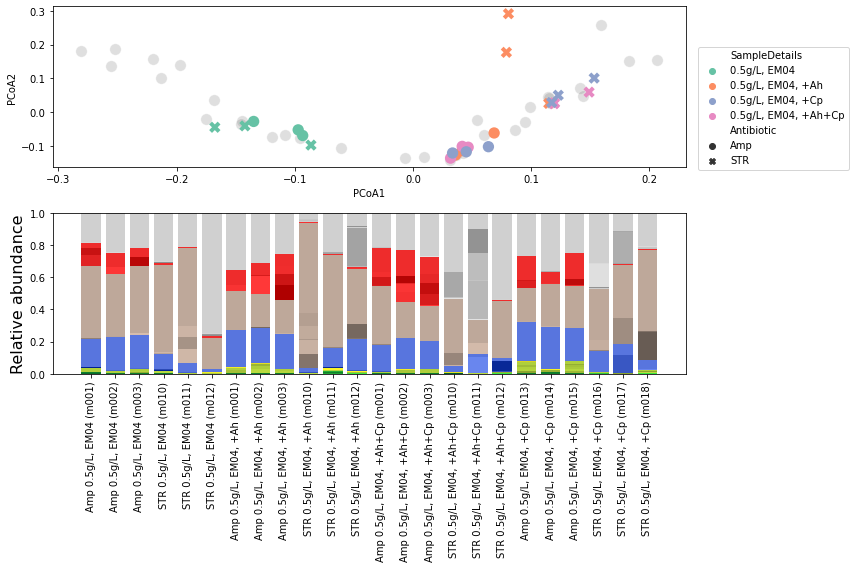

In [158]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

# plot PCOA
df2plot = deepcopy(pcoa_df)
df2plot.loc[~df2plot.SampleDetails.isin([
    'Amp 0.5g/L, EM04','STR 0.5g/L, EM04',
    'Amp 0.5g/L, EM04, +Ah','STR 0.5g/L, EM04, +Ah',
    'Amp 0.5g/L, EM04, +Cp','STR 0.5g/L, EM04, +Cp',
    'Amp 0.5g/L, EM04, +Ah+Cp','STR 0.5g/L, EM04, +Ah+Cp',
]), 'SampleDetails'] = 'Other'
df2plot['SampleDetails'] = [x.replace('Amp ','').replace('STR ','') for x in df2plot.SampleDetails]
df2plot = df2plot.sort_values(['SampleDetails','Antibiotic'])

_ = sns.scatterplot(x='PCoA1', y='PCoA2', hue='SampleDetails', style='Antibiotic', edgecolor='None', data=df2plot[df2plot.SampleDetails!='Other'], s=128, palette='Set2', ax=ax[0], 
                    hue_order=['0.5g/L, EM04','0.5g/L, EM04, +Ah','0.5g/L, EM04, +Cp','0.5g/L, EM04, +Ah+Cp'])
_ = sns.scatterplot(x='PCoA1', y='PCoA2', data=df2plot[df2plot.SampleDetails=='Other'], s=128, ax=ax[0], color='gray', alpha=0.25, zorder=-10)
_ = ax[0].legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)


# Barplot
unique_color = df_tax[['HexColor','ColorOrder']].drop_duplicates().sort_values(by='ColorOrder').reset_index(drop=True)
df_relabun2 = deepcopy(df_relabun[df2plot[df2plot.SampleDetails!='Other'].SampleID]).T.rename({z:'%s %s (%s)'%(w,x,y) for x,y,z,w in zip(df2plot.SampleDetails, df2plot.MouseID, df2plot.SampleID, df2plot.Antibiotic)})

color_grouped_abundance = np.zeros((len(df_relabun2.index),len(unique_color.index)))
for k,o in enumerate(unique_color.ColorOrder):
    currsum = df_relabun2[set(df_relabun2.columns).intersection(set(df_tax.loc[df_tax.ColorOrder==o,'ASV']))].sum(axis=1).values
    color_grouped_abundance[:,k] = currsum
color_grouped_abundance = pd.DataFrame(color_grouped_abundance, index=df_relabun2.index, columns=unique_color.HexColor)
for k,color in enumerate(color_grouped_abundance.columns):
    _ = ax[1].bar(color_grouped_abundance.index, color_grouped_abundance[color], width=0.8, bottom=color_grouped_abundance.iloc[:,0:k].sum(axis=1), color=color)
_ = ax[1].tick_params(axis='x', labelrotation=90)

# add text
dominant_taxa_indices = np.argwhere(df_relabun2.values>=0.3)
for index_pair in dominant_taxa_indices:
    curr_row = index_pair[0]
    curr_col = index_pair[1]
    dominant_tax = df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],'Genus'].values[0]
    if dominant_tax=='<not present>':
        try_higher_level_classification = {'Family', 'Order', 'Class', 'Phylum', 'Kingdom', 'ASV'};
        for higher_tax in try_higher_level_classification:
            dominant_tax = list(df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],higher_tax])[0]
            if (dominant_tax != '<not present>'):
                break
        dominant_tax = 'Unknown '+dominant_tax
    curr_color = df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],'HexColor'].values[0]
    curr_box = list(unique_color[unique_color.HexColor==curr_color].index)[0]
    cum_sum_cmap = np.cumsum(color_grouped_abundance.iloc[curr_row,:])
    heightbefore = np.append(0,cum_sum_cmap[0:-1])
    heightafter = np.array(cum_sum_cmap)
    _ = ax[1].text(color_grouped_abundance.index[curr_row], 
               (heightafter[curr_box]+heightbefore[curr_box])/2, 
               dominant_tax,
               rotation=90,
               horizontalalignment='center',
               verticalalignment='center')
_ = ax[1].set_ylim([0,1])
_ = ax[1].set_ylabel('Relative abundance', fontsize=16)
_ = ax[1].set_yticks(np.linspace(0,1,6))

plt.tight_layout()
plt.savefig('comparison_antibiotics.png', dpi=600)

## Compare concentration

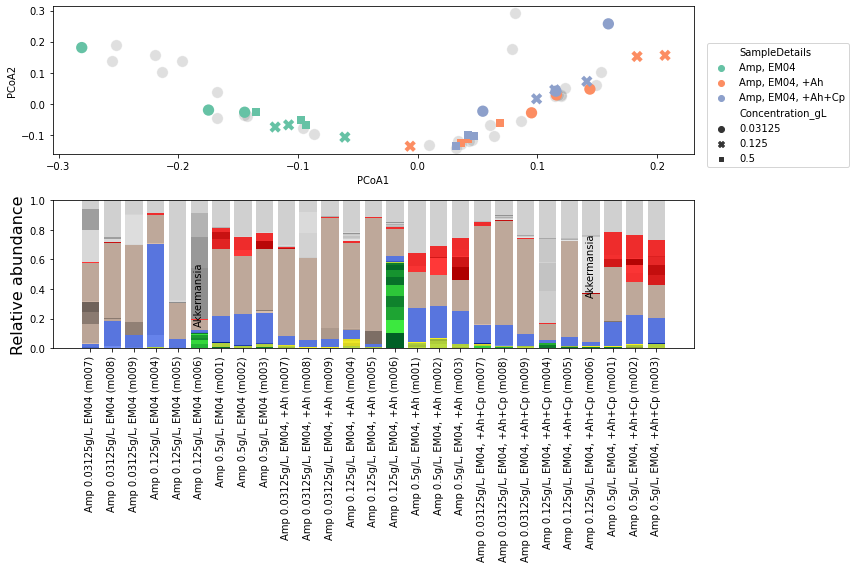

In [159]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

# plot PCOA
df2plot = deepcopy(pcoa_df)
df2plot.loc[~df2plot.SampleDetails.isin([
    'Amp 0.125g/L, EM04','Amp 0.5g/L, EM04','Amp 31.25mg/L, EM04',
    'Amp 0.125g/L, EM04, +Ah','Amp 0.5g/L, EM04, +Ah','Amp 31.25mg/L, EM04, +Ah',
    'Amp 0.125g/L, EM04, +Ah+Cp','Amp 0.5g/L, EM04, +Ah+Cp','Amp 31.25mg/L, EM04, +Ah+Cp'
]), 'SampleDetails'] = 'Other'
df2plot['SampleDetails'] = ['Amp,'+(',').join(x.split(',')[1:]) if x!='Other' else x for x in df2plot.SampleDetails]
df2plot = df2plot.sort_values(['SampleDetails','Concentration_gL'])

_ = sns.scatterplot(x='PCoA1', y='PCoA2', hue='SampleDetails', style='Concentration_gL', edgecolor='None', data=df2plot[df2plot.SampleDetails!='Other'], s=128, palette='Set2', ax=ax[0], 
                    hue_order=['Amp, EM04','Amp, EM04, +Ah','Amp, EM04, +Ah+Cp'])
_ = sns.scatterplot(x='PCoA1', y='PCoA2', data=df2plot[df2plot.SampleDetails=='Other'], s=128, ax=ax[0], color='gray', alpha=0.25, zorder=-10)
_ = ax[0].legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)

# Barplot
unique_color = df_tax[['HexColor','ColorOrder']].drop_duplicates().sort_values(by='ColorOrder').reset_index(drop=True)
df_relabun2 = deepcopy(df_relabun[df2plot[df2plot.SampleDetails!='Other'].SampleID]).T.rename({z:('%s (%s)'%(x,y)).replace('Amp','Amp %sg/L'%(w)) for x,y,z,w in zip(df2plot.SampleDetails, df2plot.MouseID, df2plot.SampleID, df2plot.Concentration_gL)})

color_grouped_abundance = np.zeros((len(df_relabun2.index),len(unique_color.index)))
for k,o in enumerate(unique_color.ColorOrder):
    currsum = df_relabun2[set(df_relabun2.columns).intersection(set(df_tax.loc[df_tax.ColorOrder==o,'ASV']))].sum(axis=1).values
    color_grouped_abundance[:,k] = currsum
color_grouped_abundance = pd.DataFrame(color_grouped_abundance, index=df_relabun2.index, columns=unique_color.HexColor)
for k,color in enumerate(color_grouped_abundance.columns):
    _ = ax[1].bar(color_grouped_abundance.index, color_grouped_abundance[color], width=0.8, bottom=color_grouped_abundance.iloc[:,0:k].sum(axis=1), color=color)
_ = ax[1].tick_params(axis='x', labelrotation=90)

# add text
dominant_taxa_indices = np.argwhere(df_relabun2.values>=0.3)
for index_pair in dominant_taxa_indices:
    curr_row = index_pair[0]
    curr_col = index_pair[1]
    dominant_tax = df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],'Genus'].values[0]
    if dominant_tax=='<not present>':
        try_higher_level_classification = {'Family', 'Order', 'Class', 'Phylum', 'Kingdom', 'ASV'};
        for higher_tax in try_higher_level_classification:
            dominant_tax = list(df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],higher_tax])[0]
            if (dominant_tax != '<not present>'):
                break
        dominant_tax = 'Unknown '+dominant_tax
    curr_color = df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],'HexColor'].values[0]
    curr_box = list(unique_color[unique_color.HexColor==curr_color].index)[0]
    cum_sum_cmap = np.cumsum(color_grouped_abundance.iloc[curr_row,:])
    heightbefore = np.append(0,cum_sum_cmap[0:-1])
    heightafter = np.array(cum_sum_cmap)
    _ = ax[1].text(color_grouped_abundance.index[curr_row], 
               (heightafter[curr_box]+heightbefore[curr_box])/2, 
               dominant_tax,
               rotation=90,
               horizontalalignment='center',
               verticalalignment='center')
_ = ax[1].set_ylim([0,1])
_ = ax[1].set_ylabel('Relative abundance', fontsize=16)
_ = ax[1].set_yticks(np.linspace(0,1,6))

plt.tight_layout()
plt.savefig('comparison_abx_concentration.png', dpi=600)

# Compare Anaerostipes relative abunadnce

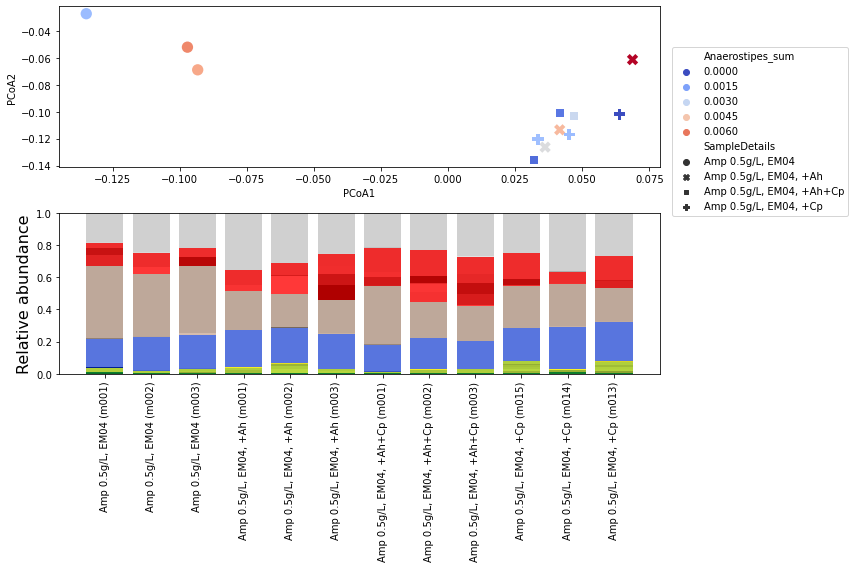

In [160]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

# plot PCOA
df2plot = deepcopy(pcoa_df)
df2plot.loc[~((df2plot.Facility=='EM04') & (df2plot.Antibiotic=='Amp') & (df2plot.Concentration_gL==0.5)), 'SampleDetails'] = 'Other'
df2plot = df2plot.sort_values(['SampleDetails'])

_ = sns.scatterplot(x='PCoA1', y='PCoA2', hue='Anaerostipes_sum', style='SampleDetails', edgecolor='None', data=df2plot[df2plot.SampleDetails!='Other'], s=128, palette='coolwarm', ax=ax[0])
_ = ax[0].legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)

# Barplot
unique_color = df_tax[['HexColor','ColorOrder']].drop_duplicates().sort_values(by='ColorOrder').reset_index(drop=True)
df_relabun2 = deepcopy(df_relabun[df2plot[df2plot.SampleDetails!='Other'].SampleID]).T.rename({z:('%s (%s)'%(x,y)) for x,y,z in zip(df2plot.SampleDetails, df2plot.MouseID, df2plot.SampleID)})

color_grouped_abundance = np.zeros((len(df_relabun2.index),len(unique_color.index)))
for k,o in enumerate(unique_color.ColorOrder):
    currsum = df_relabun2[set(df_relabun2.columns).intersection(set(df_tax.loc[df_tax.ColorOrder==o,'ASV']))].sum(axis=1).values
    color_grouped_abundance[:,k] = currsum
color_grouped_abundance = pd.DataFrame(color_grouped_abundance, index=df_relabun2.index, columns=unique_color.HexColor)
for k,color in enumerate(color_grouped_abundance.columns):
    _ = ax[1].bar(color_grouped_abundance.index, color_grouped_abundance[color], width=0.8, bottom=color_grouped_abundance.iloc[:,0:k].sum(axis=1), color=color)
_ = ax[1].tick_params(axis='x', labelrotation=90)

# add text
dominant_taxa_indices = np.argwhere(df_relabun2.values>=0.3)
for index_pair in dominant_taxa_indices:
    curr_row = index_pair[0]
    curr_col = index_pair[1]
    dominant_tax = df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],'Genus'].values[0]
    if dominant_tax=='<not present>':
        try_higher_level_classification = {'Family', 'Order', 'Class', 'Phylum', 'Kingdom', 'ASV'};
        for higher_tax in try_higher_level_classification:
            dominant_tax = list(df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],higher_tax])[0]
            if (dominant_tax != '<not present>'):
                break
        dominant_tax = 'Unknown '+dominant_tax
    curr_color = df_tax.loc[df_tax.ASV==df_relabun2.columns[curr_col],'HexColor'].values[0]
    curr_box = list(unique_color[unique_color.HexColor==curr_color].index)[0]
    cum_sum_cmap = np.cumsum(color_grouped_abundance.iloc[curr_row,:])
    heightbefore = np.append(0,cum_sum_cmap[0:-1])
    heightafter = np.array(cum_sum_cmap)
    _ = ax[1].text(color_grouped_abundance.index[curr_row], 
               (heightafter[curr_box]+heightbefore[curr_box])/2, 
               dominant_tax,
               rotation=90,
               horizontalalignment='center',
               verticalalignment='center')
_ = ax[1].set_ylim([0,1])
_ = ax[1].set_ylabel('Relative abundance', fontsize=16)
_ = ax[1].set_yticks(np.linspace(0,1,6))

plt.tight_layout()
plt.savefig('comparison_anaerostipes_level.png', dpi=600)